In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from pandas import concat

In [4]:
all_df = pd.read_csv('cleanAll7Year.csv', delimiter=',')
all_df=all_df.sort_values(['year', 'month','day','day_date','start_hour'], ascending=[True, True,True,True,True])
all_df.head(4)

,date,date_id,wind,desc,temp,baro,hum,year,month,day,day_date,start_hour,end_hour
3037,"Monday, January 5, 2015, 12:00 am — 6:00 am",1.420416e+12,1.864,Overcast.,39.2,30.47,94,2015,1,0,5,00:00,06:00
3038,"Monday, January 5, 2015, 6:00 am — 12:00 pm",1.420438e+12,3.728,Partly sunny.,48.2,30.40,93,2015,1,0,5,06:00,12:00
3039,"Monday, January 5, 2015, 12:00 pm — 6:00 pm",1.420459e+12,8.078,Partly sunny.,50.0,30.32,81,2015,1,0,5,12:00,18:00
3040,"Monday, January 5, 2015, 6:00 pm — 12:00 am",1.420481e+12,7.457,Overcast.,48.2,30.24,75,2015,1,0,5,18:00,00:00


In [36]:
# predict two feature of data with LSTM
data=all_df.set_index('date')
data= data[['wind','hum']]
data

,wind,hum
date,,
"Monday, January 5, 2015, 12:00 am — 6:00 am",1.864,94
"Monday, January 5, 2015, 6:00 am — 12:00 pm",3.728,93
"Monday, January 5, 2015, 12:00 pm — 6:00 pm",8.078,81
"Monday, January 5, 2015, 6:00 pm — 12:00 am",7.457,75
"Monday, January 12, 2015, 12:00 am — 6:00 am",18.642,72
...,...,...
"Sunday, December 19, 2021, 6:00 pm — 12:00 am",5.593,95
"Sunday, December 26, 2021, 12:00 am — 6:00 am",10.564,98
"Sunday, December 26, 2021, 6:00 am — 12:00 pm",5.593,97


In [22]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [24]:
values = data.values
# integer encode direction
encoder = LabelEncoder()
values[:,0] = encoder.fit_transform(values[:,0])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())

   var1(t-1)   var1(t)
1   0.067797  0.152542
2   0.152542  0.305085
3   0.305085  0.288136
4   0.288136  0.627119
5   0.627119  0.711864


In [25]:
# split into train and test sets
values = reframed.values
n_train_hours = 7000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7000, 1, 1) (7000,) (3221, 1, 1) (3221,)


In [26]:
# design network
model_LS = Sequential()
model_LS.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model_LS.add(Dense(1))
model_LS.compile(loss='mae', optimizer='adam')
# fit network
history = model_LS.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/10
98/98 - 3s - loss: 0.2335 - val_loss: 0.1517 - 3s/epoch - 32ms/step
Epoch 2/10
98/98 - 0s - loss: 0.1214 - val_loss: 0.1142 - 266ms/epoch - 3ms/step
Epoch 3/10
98/98 - 0s - loss: 0.1099 - val_loss: 0.1117 - 320ms/epoch - 3ms/step
Epoch 4/10
98/98 - 0s - loss: 0.1079 - val_loss: 0.1094 - 281ms/epoch - 3ms/step
Epoch 5/10
98/98 - 0s - loss: 0.1060 - val_loss: 0.1072 - 292ms/epoch - 3ms/step
Epoch 6/10
98/98 - 0s - loss: 0.1044 - val_loss: 0.1055 - 288ms/epoch - 3ms/step
Epoch 7/10
98/98 - 0s - loss: 0.1032 - val_loss: 0.1041 - 290ms/epoch - 3ms/step
Epoch 8/10
98/98 - 0s - loss: 0.1024 - val_loss: 0.1032 - 286ms/epoch - 3ms/step
Epoch 9/10
98/98 - 0s - loss: 0.1019 - val_loss: 0.1025 - 286ms/epoch - 3ms/step
Epoch 10/10
98/98 - 0s - loss: 0.1016 - val_loss: 0.1022 - 299ms/epoch - 3ms/step


In [27]:
# make a prediction
yhat = model_LS.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)

In [28]:
inv_yhat = scaler.inverse_transform(inv_yhat.reshape(-1,1))
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 18.710


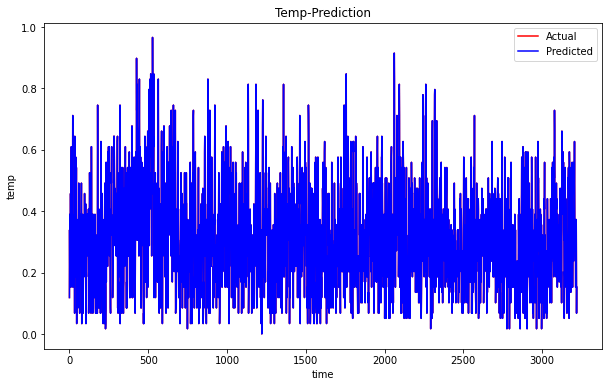

In [29]:
plt.figure(figsize=(10,6))
plt.plot(test_y, color='red', label='Actual')
plt.plot(inv_y , color='blue', label='Predicted')
plt.title('Temp-Prediction')
plt.xlabel('time')
plt.ylabel('temp')
plt.legend()
plt.show()

#The second model with LSTM 
 Sequence to Sequence Model with one encoder layer and one decoder layer.

In [33]:
#scale the values to -1 to 1.
data=all_df.set_index('date')
data= data[['temp','wind','baro','hum']]
train_df,test_df = data[1:7000], data[7000:] 
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in test_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [14]:
# sliding window approach to input past observations and output future observations to use supervised learning algorithms
def split_series(series, n_past, n_future):
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [15]:
n_past = 2
n_future = 2 
n_features = 4

In [16]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [39]:
import tensorflow as tf
# Sequence to Sequence Model with one encoder layer and one decoder layer.

# encoder
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs = encoder(encoder_inputs)
encoder_states = encoder_outputs[1:]
# decoder
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs[0])
decoder = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states)
decoder_outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder)
#model
model = tf.keras.models.Model(encoder_inputs,decoder_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2, 4)]       0           []                               
                                                                                                  
 lstm_8 (LSTM)                  [(None, 100),        42000       ['input_3[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector_2 (RepeatVector)  (None, 2, 100)      0           ['lstm_8[0][0]']                 
                                                                                            

In [41]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history=model.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

In [42]:
pred=model.predict(X_test)

In [43]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred[:,:,index]=scaler.inverse_transform(pred[:,:,index])
    pred[:,:,index]=scaler.inverse_transform(pred[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [45]:
from sklearn.metrics import mean_absolute_error
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,2):
    print("time",j,":")
    print("MAE : ",mean_absolute_error(y_test[:,j-1,index],pred[:,j-1,index]),end=", ")
  print()
  print()

temp
time 1 :
MAE :  2204.216509495925, 

wind
time 1 :
MAE :  160.0089284936067, 

baro
time 1 :
MAE :  89.19621921592633, 

hum
time 1 :
MAE :  2923.2319796497904, 

